# Анализ данных и алгоритмы машинного обучения

1. Математические библиотеки Python и их применение для анализа/предобработки данных - пример полиномиальной регрессии
1. Кластеризация данных и ее роль в отборе признаков и пре-процессинге
2. Анализ продуктовой корзины

__Для работы потребуются следующе датасеты:__
- [data/web_traffic.tsv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/web_traffic.tsv)
- [data/store_data.csv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/store_data.csv)

Для некоторых датасетов, которые мы будем сегодня загружать из интернета, может потребоваться порядка 500МБ дискового простанства.


__ВНИМАНИЕ__! Установите библиотеки scipy, sklearn и mlxtend: ```pip install scipy sklearn mlxtend```

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy as sp
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (10.0, 10.0)
%matplotlib inline

### Пример применения полиномиальной регрессии для моделирования данных

Допустим, у нас есть ежечасная статистика веб-траффика по некоторому серверу. Нам нужно определить, когда по времени, с учетом текущей динамики, количество запросов превысит 50000/час, чтобы заранее проапгрейдить оборудование. Для этого мы попытаемся построить кривую с помощью полиномиальной регрессии и экстраполируя ее на будущее, определим крайний срок для апгрейда оборудования.

In [2]:
web_traffic = pd.read_csv('data/web_traffic.tsv', sep='\t', header=None, names=['Hour', 'ReqsPerHour'], index_col='Hour')
web_traffic.head()

,ReqsPerHour
Hour,
1,2272.0
2,NaN
3,1386.0
4,1365.0
5,1488.0


Разберемся с пропущенными данными:

In [3]:
web_traffic.isnull().sum()

ReqsPerHour    8
dtype: int64

In [4]:
web_traffic.dropna(inplace=True)

In [5]:
web_traffic.shape

(735, 1)

Напишем функцию для красивого отображения данных и моделей:

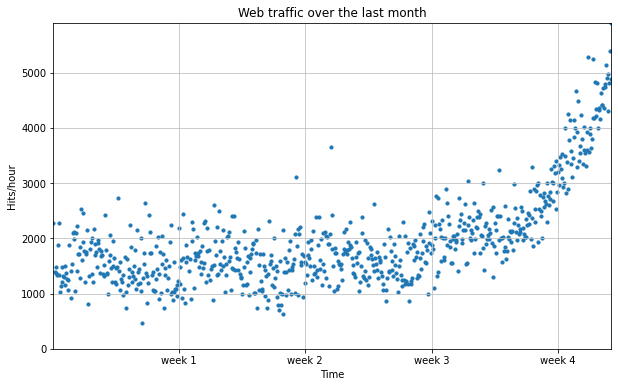

In [8]:
def plot_models(x, y, models, mx=None, ymax=None, xmin=None):
    ''' plot input data '''
    
    colors = ['g', 'k', 'b', 'm', 'r']
    linestyles = ['-', '-.', '--', ':', '-']

    plt.figure(num=None, figsize=(10, 6))
    plt.clf()
    
    plt.scatter(x, y, s=10)
    
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks(
        [w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])

    if models:
        if mx is None:
            mx = np.linspace(0, x.shape[0], 1000)
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeffs
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)
    plt.grid(True, linestyle='-', color='0.75')
    
plot_models(web_traffic.index, web_traffic.ReqsPerHour, None)

In [6]:
x, y = web_traffic.index, web_traffic.ReqsPerHour

fp1, res1, rank1, sv1, rcond1 = np.polyfit(x, y, 1, full=True)
print("Model parameters of fp1: %s" % fp1)
print("Error of the model of fp1:", res1)
f1 = sp.poly1d(fp1)

Model parameters of fp1: [  2.59619213 989.02487106]
Error of the model of fp1: [3.17389767e+08]


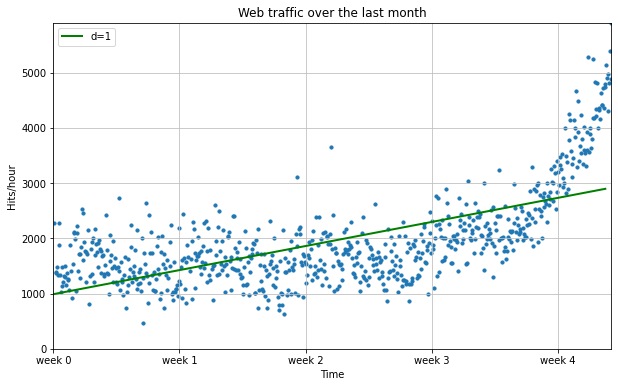

In [9]:
plot_models(x, y, [f1])

Обучим еще несколько моделей с более высокой степенью многочлена:

In [10]:
fp2, res2, rank2, sv2, rcond2 = np.polyfit(x, y, 2, full=True)
print("Model parameters of fp2: %s" % fp2)
print("Error of the model of fp2:", res2)
f2 = sp.poly1d(fp2)
f3 = sp.poly1d(np.polyfit(x, y, 3))
f10 = sp.poly1d(np.polyfit(x, y, 10))
f100 = sp.poly1d(np.polyfit(x, y, 100))

Model parameters of fp2: [ 1.05322215e-02 -5.26545650e+00  1.97476082e+03]
Error of the model of fp2: [1.79983508e+08]


/Users/ise/Documents/Works/yusen/intrapy/lib/python3.7/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/ise/Documents/Works/yusen/intrapy/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/ise/Documents/Works/yusen/intrapy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Нарисуем эти модели

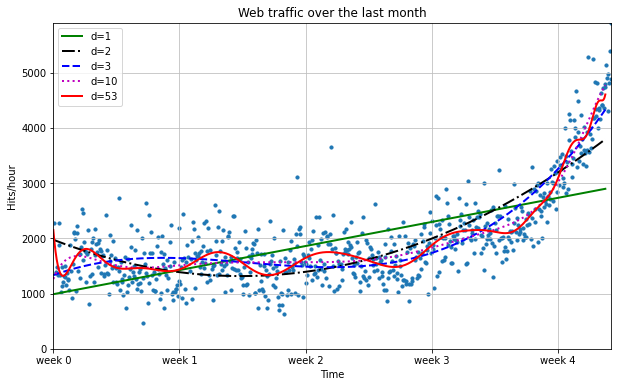

In [11]:
plot_models(x, y, [f1, f2, f3, f10, f100])

Замечаем, что точка перегиба нашего графика находится примерно на середине второй недели. Повторим обучение наших моделей с этим смещением.

In [12]:
# fit and plot a model using the knowledge about inflection point
inflection = int(2.5 * 7 * 24)
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = sp.poly1d(np.polyfit(xa, ya, 1))
fb = sp.poly1d(np.polyfit(xb, yb, 1))

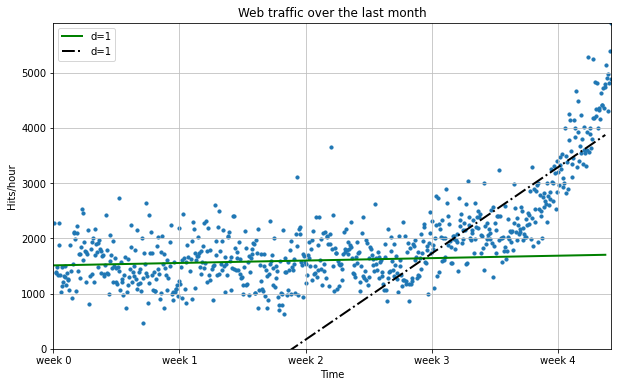

In [13]:
plot_models(x, y, [fa, fb])

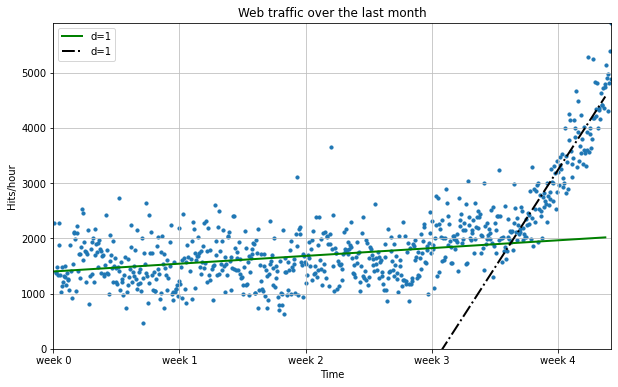

In [14]:
# fit and plot a model using the knowledge about inflection point
inflection = int(3.5 * 7 * 24)
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = sp.poly1d(np.polyfit(xa, ya, 1))
fb = sp.poly1d(np.polyfit(xb, yb, 1))
plot_models(x, y, [fa, fb])

Нарисуем существующие модели с экстраполяцией в недалекое будущее (до 6-й недели с начала наблюдений)

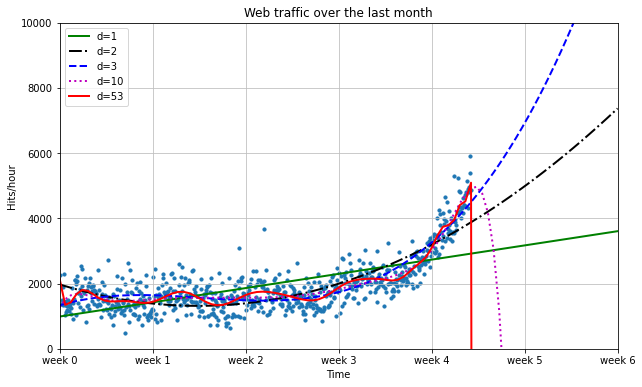

In [15]:
plot_models(
    x, y, [f1, f2, f3, f10, f100],
    mx=np.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

А также создадим несколько моделей, обученных на данных только после второй точки перегиба:

In [16]:
fb1 = fb
fb2 = sp.poly1d(np.polyfit(xb, yb, 2))
fb3 = sp.poly1d(np.polyfit(xb, yb, 3))
fb10 = sp.poly1d(np.polyfit(xb, yb, 10))
fb100 = sp.poly1d(np.polyfit(xb, yb, 100))

/Users/ise/Documents/Works/yusen/intrapy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ise/Documents/Works/yusen/intrapy/lib/python3.7/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/ise/Documents/Works/yusen/intrapy/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/ise/Documents/Works/yusen/intrapy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Нарисуем их:

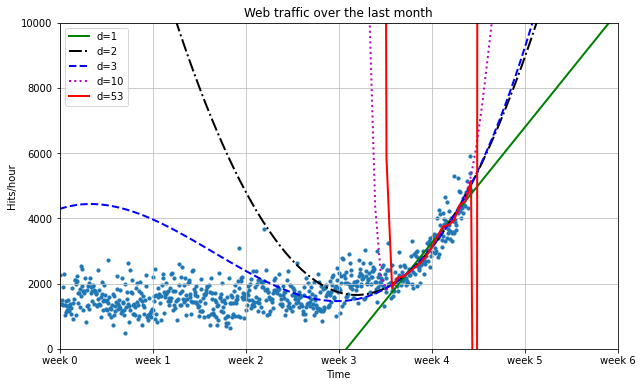

In [17]:
plot_models(
    x, y, [fb1, fb2, fb3, fb10, fb100],
    mx=np.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

#### Оценим точность 

Напишем функцию которая считает среднеквадратичную ошибку для модели и посмотрим, на сколько точны наши первоначальные модели:

In [18]:
def error(f, x, y):
    return np.sum((f(x) - y) ** 2)

print("Errors for the complete data set:")
for f in [f1, f2, f3, f10, f100]:
    print("Error d={}: {}" .format (f.order, error(f, x, y)))

Errors for the complete data set:
Error d=1: 317389767.339778
Error d=2: 179983507.8781792
Error d=3: 139350144.03172523
Error d=10: 121942326.36358732
Error d=53: 109452415.64865392


...и оценим их же точность, но только после точки перегиба:

In [19]:
print("Errors for only the time after inflection point")
for f in [f1, f2, f3, f10, f100]:
    print("Error d={}: {}" .format(f.order, error(f, xb, yb)))

Errors for only the time after inflection point
Error d=1: 145045835.1344727
Error d=2: 61116348.80962042
Error d=3: 33214248.905597426
Error d=10: 21611594.263691925
Error d=53: 18656112.706603393


...и теперь точность моделей, обученных после точки перегиба:

In [20]:
print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

Errors for only the time after inflection point
Error d=1: 22143941.107618
Error d=2: 19768846.989176
Error d=3: 19766452.361027
Error d=10: 18949296.721348
Error d=53: 18300632.873443


Выберем победительницей модель с полиномом в степени 2. Рассчитаем дату достижения предела в 50000 запросов.

In [21]:
from scipy.optimize import fsolve
reached_max = fsolve(fb2 - 50000, x0=800) / (7 * 24)
print("50,000 hits/hour expected at week %f" % reached_max[0])

50,000 hits/hour expected at week 7.852258


Нарисуем:

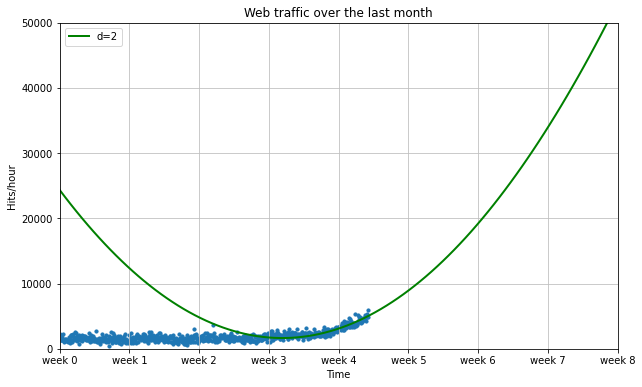

In [22]:
plot_models(
    x, y, [fb2],
    mx=np.linspace(0 * 7 * 24, 8 * 7 * 24, 100),
    ymax=50000, xmin=0 * 7 * 24)

### Пример 2. Кластеризация 

В качестве визуальной оценки данных используется кластеризация.

In [24]:
!pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 7.2 MB 1.4 MB/s eta 0:00:01     |█████████████████▍              | 3.9 MB 1.3 MB/s eta 0:00:03     |█████████████████████▍          | 4.8 MB 1.3 MB/s eta 0:00:02     |███████████████████████████████▋| 7.1 MB 1.4 MB/s eta 0:00:01
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
     |████████████████████████████████| 303 kB 1.8 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=25e8cc49aa13e28f2fe65bd50be101d0c3f71bf6c17882c60f8c944630930c2c
  Stored in directory: /Users/ise/Library/Caches/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
You should consider upgrading via the '/Users/ise/Documents/Works/yusen/intrapy/bin/python3 -m pip install --upgrade pip' command.


In [25]:
from sklearn.decomposition import PCA

Метод PCA (метод главных компонент) позволяет уменьшить размерность датасета до 2 (или 3).  Это позволяет визуально оценить "обучаемость" алгоритмов на этих данных. Также метод позволяет выяснить, из чего состоят итоговые компоненты. В основе этого метода лежит сингулярное разложение векторов (SVD). Рассмотрим на примере набора данных "Ирисы":

In [30]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data, iris.target

iris.data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

Meaning of the 2 components:
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


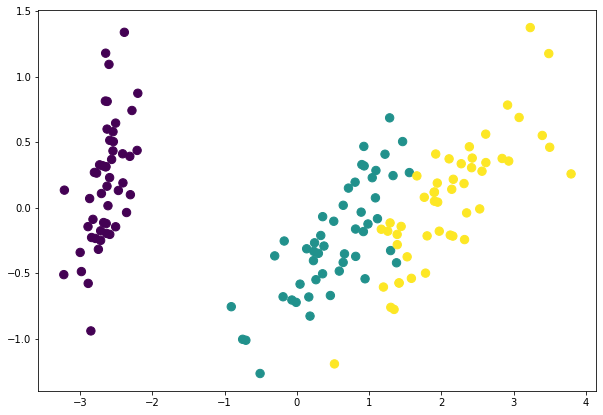

In [33]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))
plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=70, cmap='viridis')
plt.show()

Text(0.5, 0, 'z')

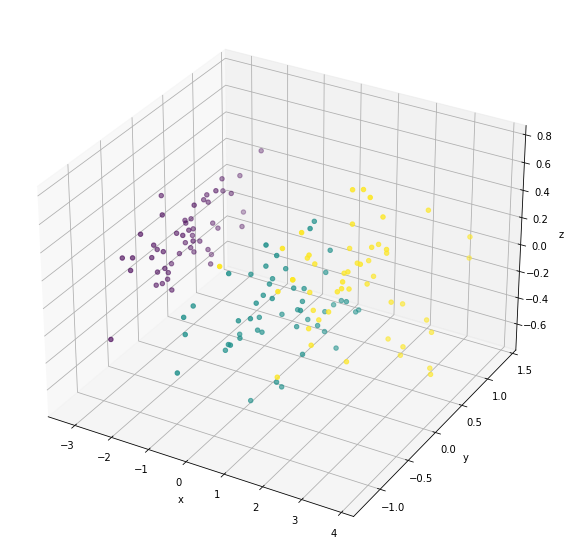

In [34]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter( X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap=plt.cm.get_cmap('viridis'))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Рассмотрим на примере датасета "рукописные цифры". Здесь размерность уменьшена с 64 до 2.

Projecting 64-dimensional data to 2D


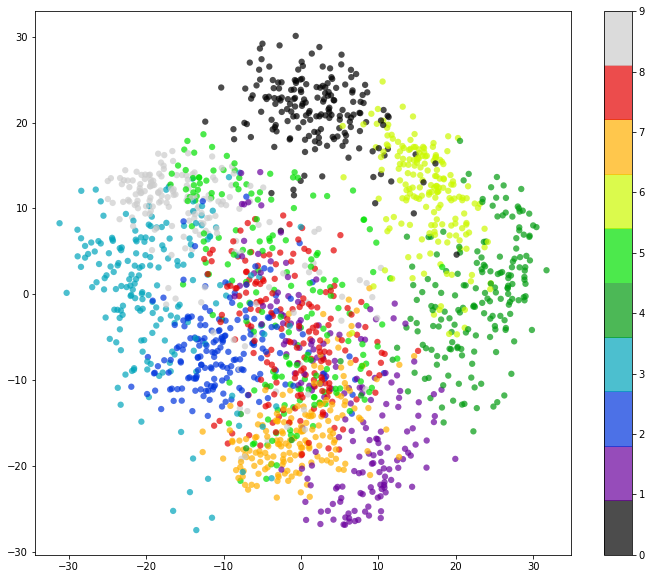

In [46]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target


pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

No handles with labels found to put in legend.


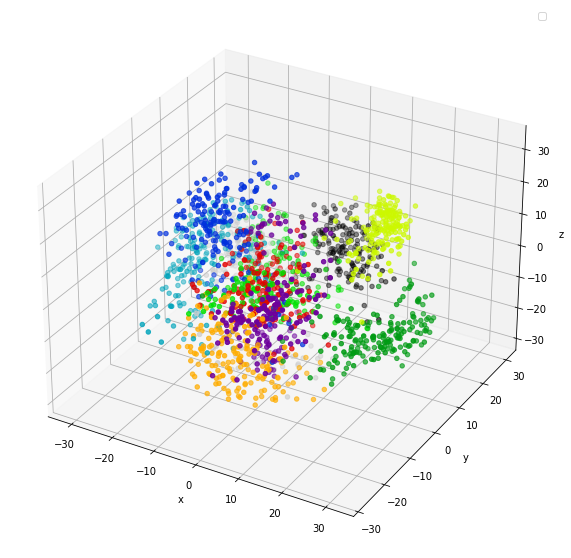

In [47]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter( X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap=plt.cm.get_cmap('nipy_spectral'))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()

Пример кластеризации по t-SNE.

<AxesSubplot:>

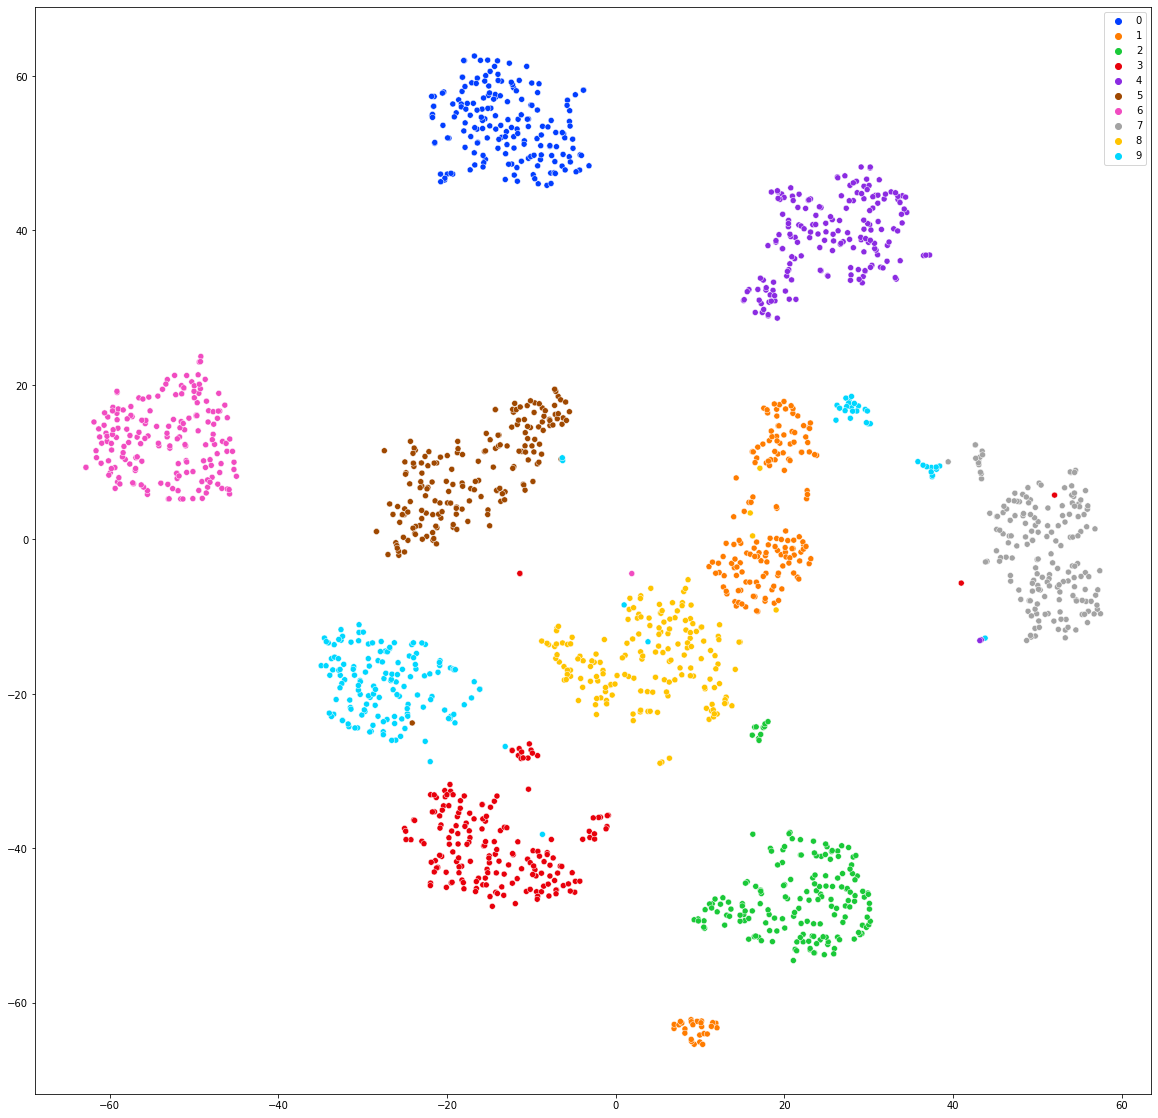

In [48]:
from sklearn.manifold import TSNE

plt.figure(figsize=(20,20))

tsne = TSNE()
X_embedded = tsne.fit_transform(X)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=sns.color_palette("bright", 10))

Text(0.5, 0, 'z')

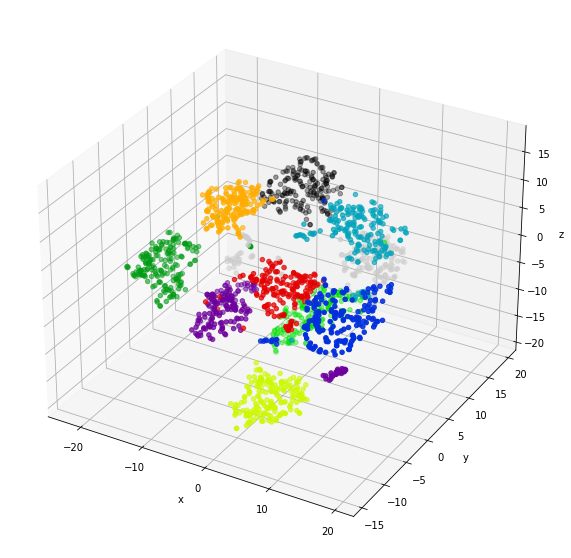

In [49]:
tsne = TSNE(n_components=3)
X_embedded = tsne.fit_transform(X)

ig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter( X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap=plt.cm.get_cmap('nipy_spectral'))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

### Пример 3. Анализ покупательской корзины

Это пример "майнинга данных" - поиска зависимостей и закономерностей в массиве данных. "Анализ покупательской корзины" - довольно часто использующийся метод при построении рекомендательных систем. Базовый алгоритм называется ```Apriori```, он был предложен в 1994 году.

Назначение алгоритма - поиск часто встречающихся подмножеств. Он оперирует следующими понятиями:
 - "суппорт" $Support A$ - вероятность покупки товара A, ее можно вычислить как отношение количества покупок A к общему количеству покупок.
 - "конфидент" $Conf  A{\rightarrow}B$  - вычисляется для пары товаров A и B как отношение случаев совместного приобретения этих товаров к покупкам артикула A
 - "подъем" $Lift  A{\rightarrow}B$  - это отношение вероятности приобретения пары товаров A и B к вероятности приобретения товара A. Или попросту говоря, отношение "конфидента" к "суппорту".
 
Давайте "вытащим" из датасета с данными о покупках в некотором французском супермаркете самые популярные товары и их сочетания с помощью алгоритма ```Apriori```.


Прочитаем датасет и посмотрим на его содержимое:

In [50]:
df_store = pd.read_csv('data/store_data.csv', header=None)
print(df_store.shape)
df_store.head()

(7501, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим на список артикулов и их количество:

In [56]:
df_store.stack().value_counts()

mineral water    1788
eggs             1348
spaghetti        1306
french fries     1282
chocolate        1230
                 ... 
bramble            14
cream               7
napkins             5
water spray         3
 asparagus          1
Length: 120, dtype: int64

На базе исходного dataframe создадим dataframe, в котором признаки приобретения того или иного товара станут булевыми dummy признаками. Для этого мы ему сначала сделаем ```stack()```, получим dummy-признаки, а затем сгруппируем по индексу первого уровня со взятием максимума:

In [67]:
df_dummies = pd.get_dummies(df_store.stack()).groupby(level=0).max()
df_dummies.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,0,1,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Запустим алгоритм Apriori и получим список наиболее часто приобретаемых товаров и их сочетаний:

In [70]:
from mlxtend.frequent_patterns import apriori

df_apriori = apriori(df_dummies, min_support=0.01, use_colnames=True)
df_apriori

,support,itemsets
0,0.020397,(almonds)
1,0.033329,(avocado)
2,0.010799,(barbecue sauce)
3,0.014265,(black tea)
4,0.011465,(body spray)
...,...,...
252,0.011065,"(milk, ground beef, mineral water)"
253,0.017064,"(spaghetti, ground beef, mineral water)"
254,0.015731,"(spaghetti, milk, mineral water)"
255,0.010265,"(spaghetti, olive oil, mineral water)"


Отсортируем список:

In [71]:
df_apriori.sort_values('support', ascending=False)

,support,itemsets
46,0.238368,(mineral water)
19,0.179709,(eggs)
63,0.174110,(spaghetti)
24,0.170911,(french fries)
13,0.163845,(chocolate)
...,...,...
255,0.010265,"(spaghetti, olive oil, mineral water)"
123,0.010132,"(chocolate, soup)"
246,0.010132,"(eggs, ground beef, mineral water)"
249,0.010132,"(spaghetti, french fries, mineral water)"


Теперь получим список самых популярных сочетаний для 2-х и 3-х товаров в корзине:

In [74]:
df_apriori['item_count'] = df_apriori['itemsets'].apply(len)
df_apriori[ df_apriori.item_count >=3 ].sort_values('support', ascending=False)[:20]

,support,itemsets,item_count
253,0.017064,"(spaghetti, ground beef, mineral water)",3
245,0.015865,"(spaghetti, chocolate, mineral water)",3
254,0.015731,"(spaghetti, milk, mineral water)",3
248,0.014265,"(spaghetti, eggs, mineral water)",3
243,0.013998,"(chocolate, milk, mineral water)",3
240,0.013465,"(chocolate, eggs, mineral water)",3
247,0.013065,"(eggs, milk, mineral water)",3
251,0.011998,"(spaghetti, frozen vegetables, mineral water)",3
256,0.011465,"(spaghetti, pancakes, mineral water)",3
250,0.011065,"(frozen vegetables, milk, mineral water)",3


4. Нейронные сети

В рамках данной демонстрации мы, конечно, не будем углубляться во все тонкости обучения, настройки и использования нейросетей, это тема для отдельного курса. Ниже - просто пример использования сети imagenet в задаче распознавания образов: 

In [97]:
!pip install tensorflow keras

You should consider upgrading via the '/Users/ise/Documents/Works/yusen/intrapy/bin/python3 -m pip install --upgrade pip' command.


In [98]:
import keras
keras.__version__

'2.5.0'

In [99]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

model = VGG16(weights='imagenet')

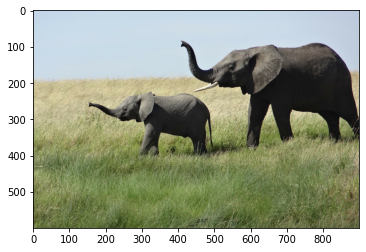

In [101]:
# Загрузим изображение
img_path = 'data/creative_commons_elephant.jpg'

img_full = image.load_img(img_path)
plt.imshow(img_full)

In [102]:
# выполним необходимый пре-процессинг изображения и вызовем функцию predict()

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.90942115), ('n01871265', 'tusker', 0.08618289), ('n02504013', 'Indian_elephant', 0.004354583)]


In [103]:
# узнать об архитектуре и свойствах модели можно с помощью функции summary()

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     